# Analysis of a Twitter Social Network

In this section we are going to parse the tweets we collected and build the social network of interactions between Twitter users. We will also see how to analyze the network using NetworkX.

## Parsing tweets

Tweets are saved in JSON format ([JavaScript Object Notation](https://www.w3schools.com/js/js_json_intro.asp))
JSON is text, written with JavaScript object notation.

The `json` python module allows to easily import json file into python [Dictonairies](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)



In [8]:
#load tweets 

import json

filename = 'trumpTweets3.txt'

tweet_list = []

with open(filename, 'r') as fopen:
    # each line correspond to a tweet
    for line in fopen:
        if line != '\n':
            tweet_list.append(json.loads(line))
        

Let's look at the informations contained in a tweet

In [9]:
# take the first tweet of the list
tweet = tweet_list[2]

In [10]:
# each tweet is a python dictionary
type(tweet)

dict

In [11]:
# all the 'entries' of the dictionary
tweet.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms'])

you can find a description of the fields in the Twitter API documentation: https://dev.twitter.com/overview/api/tweets

In [12]:
#creation time
tweet['created_at']

'Thu Apr 27 17:54:29 +0000 2017'

In [13]:
# text of the tweet
print(tweet['text'])

RT @SenWarren: .@realDonaldTrump ran 4 companies through bankruptcy. Now he plans to bankrupt our country.


In [14]:
# user info
tweet['user']

{'contributors_enabled': False,
 'created_at': 'Fri Jul 29 20:11:47 +0000 2011',
 'default_profile': False,
 'default_profile_image': False,
 'description': 'Proud Liberal and Progressive raised in the sticks by The Greatest Generation Grandparents to respect all people, work hard and look out for your fellow man.',
 'favourites_count': 2649,
 'follow_request_sent': None,
 'followers_count': 112,
 'following': None,
 'friends_count': 612,
 'geo_enabled': False,
 'id': 344926679,
 'id_str': '344926679',
 'is_translator': False,
 'lang': 'en',
 'listed_count': 0,
 'location': 'Shelbyville, Mo',
 'name': 'Shana Hicks',
 'notifications': None,
 'profile_background_color': 'FFF04D',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme19/bg.gif',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme19/bg.gif',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/846725656113303553/4Zv7VUuq_normal.jpg',

In [15]:
# user is itslef a dict
print(type(tweet['user']))

tweet['user']['name']

<class 'dict'>


'Shana Hicks'

In [16]:
# unique id of the user
tweet['user']['id']

344926679

In [17]:
#is the tweet a retweet?
'retweeted_status' in tweet

True

In [18]:
if 'retweeted_status' in tweet:
    print(tweet['retweeted_status'])
# the `retweeted_status` is also a tweet dictionary    

{'created_at': 'Thu Apr 27 17:35:04 +0000 2017', 'id': 857649309420072966, 'id_str': '857649309420072966', 'text': '.@realDonaldTrump ran 4 companies through bankruptcy. Now he plans to bankrupt our country.', 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 970207298, 'id_str': '970207298', 'name': 'Elizabeth Warren', 'screen_name': 'SenWarren', 'location': None, 'url': 'http://warren.senate.gov', 'description': 'Official twitter account of Senator Elizabeth Warren of Massachusetts.', 'protected': False, 'verified': True, 'followers_count': 2266186, 'friends_count': 259, 'listed_count': 11704, 'favourites_count': 7, 'statuses_count': 1869, 'created_at': 'Sun Nov 25 15:14:27 +0000 2012', 'utc_offset': -14400, 'time_zone': 'Eastern Time (US & Canada)', 'geo_enable

In [19]:
# user id and name of the retweeted user?
if 'retweeted_status' in tweet:
    print(tweet['retweeted_status']['user']['id'])
    print(tweet['retweeted_status']['user']['name'])

970207298
Elizabeth Warren


In [20]:
# is the tweet a reply?
'in_reply_to_user_id' in tweet and tweet['in_reply_to_user_id'] is not None

False

In [21]:
# 'entities' contains the hashtags, urls and usernames used in the tweet
tweet['entities']

{'hashtags': [],
 'symbols': [],
 'urls': [],
 'user_mentions': [{'id': 970207298,
   'id_str': '970207298',
   'indices': [3, 13],
   'name': 'Elizabeth Warren',
   'screen_name': 'SenWarren'},
  {'id': 25073877,
   'id_str': '25073877',
   'indices': [16, 32],
   'name': 'Donald J. Trump',
   'screen_name': 'realDonaldTrump'}]}

In [22]:
# user id of the mentioned users
for  mention in tweet['entities']['user_mentions']:
    print(mention['id'])

970207298
25073877


In [23]:
# is the tweet a quote?
'quoted_status' in tweet

False

# Building the network of interactions

We will use the python module [`NetworkX`](https://networkx.readthedocs.io/en/stable/index.html) to construct and analyze the social network.

A short introduction to networkx: https://github.com/networkx/notebooks


There are four types of interactions between two users in Twitter:
- Retweet
- Quote
- Reply
- Mention

In [24]:
# let's define some functions to extract the interactions from tweets

def getTweetID(tweet):
    """ If properly included, get the ID of the tweet """
    return tweet.get('id')
    
def getUserIDandScreenName(tweet):
    """ If properly included, get the tweet 
        user ID and Screen Name """
    user = tweet.get('user')
    if user is not None:
        uid = user.get('id')
        screen_name = user.get('screen_name')
        return uid, screen_name
    else:
        return (None, None)

def getRetweetedUserIDandSreenName(tweet):
    """ If properly included, get the retweet 
        source user ID and Screen Name"""
    
    retweet = tweet.get('retweeted_status')
    if retweet is not None:
        return getUserIDandScreenName(retweet)
    else:
        return (None, None)
    
def getRepliedUserIDandScreenName(tweet):
    """ If properly included, get the ID and Screen Name 
        of the user the tweet replies to """
    
    reply_id = tweet.get('in_reply_to_user_id')
    reply_screenname = tweet.get('in_reply_to_screen_name')
    return reply_id, reply_screenname
    
def getUserMentionsIDandScreenName(tweet):
    """ If properly included, return a list of IDs and Screen Names tuple
        of all user mentions, including retweeted and replied users """
        
    mentions = []
    entities = tweet.get('entities')
    if entities is not None:
        user_mentions = entities.get('user_mentions')
        for mention in user_mentions:
            mention_id = mention.get('id')
            screen_name = mention.get('screen_name')
            mentions.append((mention_id, screen_name))
    
    return mentions

    
def getQuotedUserIDandScreenName(tweet):
    """ If properly included, get the ID of the user the tweet is quoting"""
    
    quoted_status = tweet.get('quoted_status')
    
    if quoted_status is not None:
        return getUserIDandScreenName(quoted_status)
    else:
        return (None, None)
    
def getAllInteractions(tweet):
    """ Get all the interactions from this tweet
    
        returns : (tweeter_id, tweeter_screenname), list of (interacting_id, interacting_screenname)
    """
    
    # Get the tweeter
    tweeter = getUserIDandScreenName(tweet)
    
    # Nothing to do if we couldn't get the tweeter
    if tweeter[0] is None:
        return (None, None), []
    
    # a python set is a collection of unique items
    # we use a set to avoid duplicated ids
    interacting_users = set()
    
    # Add person they're replying to
    interacting_users.add(getRepliedUserIDandScreenName(tweet))
    
    # Add person they retweeted
    interacting_users.add(getRetweetedUserIDandSreenName(tweet))
    
    # Add person they quoted
    interacting_users.add(getQuotedUserIDandScreenName(tweet))
    
    # Add mentions
    interacting_users.update(getUserMentionsIDandScreenName(tweet))
  
    # remove the tweeter if he is in the set
    interacting_users.discard(tweeter)
    # remove the None case
    interacting_users.discard((None,None))
    
    # Return our tweeter and their influencers
    return tweeter, list(interacting_users)
    


In [25]:
print(getUserIDandScreenName(tweet))
print(getAllInteractions(tweet))

(344926679, 'HicksShana')
((344926679, 'HicksShana'), [(25073877, 'realDonaldTrump'), (970207298, 'SenWarren')])


#### Let's build the network

In [26]:
import networkx as nx

# define an empty Directed Graph
# A directed graph is a graph where edges have a direction
# in our case the edges goes from user that sent the tweet to
# the user with whom they interacted (retweeted, mentioned or quoted)
G = nx.DiGraph()

# loop over all the tweets and add edges if the tweet include some interactions
for tweet in tweet_list:
    # find all influencers in the tweet
    tweeter, interactions = getAllInteractions(tweet)
    tweeter_id, tweeter_name = tweeter
    
    # add an edge to the Graph for each influencer
    for interaction in interactions:
        interact_id, interact_name = interaction
        
        # add edges between the two user ids
        # this will create new nodes if the nodes are not already in the network
        G.add_edge(tweeter_id, interact_id)
        
        # add name as a property to each node
        # with networkX each node is a dictionary
        G.node[tweeter_id]['name'] = tweeter_name
        G.node[interact_id]['name'] = interact_name
        

In [27]:
# The graph's node are contained in a dictionary 
print(type(G.node))


<class 'dict'>


In [28]:
#print(G.node.keys())
# the keys are the user_id
print(G.node[tweeter_id])


{'name': 'sjporter51'}


In [29]:
# each node is itself a dictionary with node attributes as key,value pairs
print(type(G.node[tweeter_id]))

<class 'dict'>


In [30]:
# edges are also contained in a dictionary
print(type(G.edge))


<class 'dict'>


In [31]:
# we can see all the edges going out of this node
# each edge is a dictionary inside this dictionary with a key 
# corresponding to the target user_id
print(G.edge[tweeter_id])

{25073877: {}, 970207298: {}}


In [32]:
# so we can access the edge using the source user_id and the target user_id
G.edge[tweeter_id][interact_id]

{}

#### Some basic properties of the Network:

In [33]:
G.number_of_nodes()

2805

In [34]:
G.number_of_edges()

3064

In [35]:
# listing all nodes 
node_list = G.nodes()
node_list[:3]

[95689285, 25073877, 19781705]

In [36]:
# degree of a node
print(G.degree(node_list[2]))
print(G.in_degree(node_list[2]))
print(G.out_degree(node_list[2]))

1
1
0


In [37]:
# dictionary with the degree of all nodes
all_degrees = G.degree(node_list) # this is the degree for undirected edges
in_degrees = G.in_degree(node_list)
out_degrees = G.in_degree(node_list)

In [38]:
# average degree
2*G.number_of_edges()/G.number_of_nodes()

2.184670231729055

In [39]:
import numpy as np
np.array(list(all_degrees.values())).mean()

2.1846702317290552

In [40]:
np.array(list(in_degrees.values())).mean()

1.0923351158645276

In [41]:
np.array(list(out_degrees.values())).mean()

1.0923351158645276

In [42]:
# maximum degree
max(all_degrees.values())

471

In [43]:
# we want to make a list with (user_id, username, degree) for all nodes
degree_node_list = []
for node in G.nodes_iter():
    degree_node_list.append((node, G.node[node]['name'], G.degree(node)))
    
print('Unordered user, degree list')    
print(degree_node_list[:10])

# sort the list according the degree in descinding order
degree_node_list = sorted(degree_node_list, key=lambda x:x[2], reverse=True)
print('Ordered user, degree list')    
print(degree_node_list[:10])

Unordered user, degree list
[(95689285, 'iheartawkward', 3), (25073877, 'realDonaldTrump', 471), (19781705, 'achibrunette', 1), (736959136164806657, 'JacobAWohl', 1), (28488678, 'linadmd_', 12), (137794015, 'RepTedDeutch', 1), (822215679726100480, 'POTUS', 38), (2853309155, 'RepCurbelo', 1), (822957022467465216, 'MdeDefarge', 1), (344926679, 'HicksShana', 3)]
Ordered user, degree list
[(25073877, 'realDonaldTrump', 471), (970207298, 'SenWarren', 64), (30364057, 'SarahKSilverman', 57), (760125196007247872, 'patsfandove', 56), (2316383071, 'RVAwonk', 50), (32871086, 'kylegriffin1', 41), (822215679726100480, 'POTUS', 38), (36686040, 'MaxineWaters', 38), (19346439, 'LouiseMensch', 38), (818927131883356161, 'PressSec', 36)]


In [44]:
# we need to import matplolib for making plots
# and numpy for numerical computations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/alex/anaconda/envs/networklessons/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/alex/anaconda/envs/networklessons/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/alex/anaconda/envs/networklessons/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Network components

For **directed** graphs we can define two types of components:
- Weakly connected components
- Strongly connected components

Weakly connected component (WCC): maximal set of nodes where there exists a path in at least one direction between each pair of nodes.

Strongly connected component (SCC): maximal set of nodes where there exists a path in both directions between each pair of nodes.

Weakly connected giant (largest) component (WCGC): Largest WCC
Strongly connected giant (largest) component (SCGC): Largest SCC

<img src="network_components.svg" style="width: 250px;"/>

In [45]:
# this returns a list of set of nodes belonging to the 
# different (weakly) connected components
components = list(nx.weakly_connected_components(G))

# sort the component according to their size
components = list(sorted(components, key=lambda x:len(x), reverse=True))

In [46]:
# make a list with the size of each component
comp_sizes = []
for comp in components:
    comp_sizes.append(len(comp))

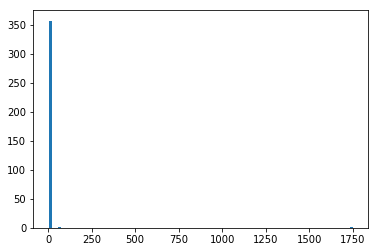

In [47]:
# plot the histogram of component sizes
hist = plt.hist(comp_sizes, bins=100)

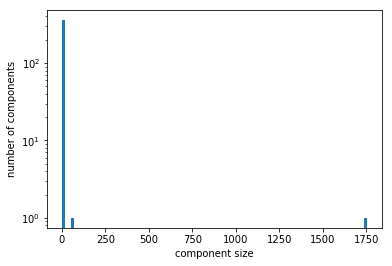

In [48]:
# histogram with logarithmic y scale
hist = plt.hist(comp_sizes, bins=100, log=True)
plt.xlabel('component size')
plt.ylabel('number of components')

In [49]:
# sizes of the ten largest components
comp_sizes[:10]

[1751, 66, 13, 12, 11, 10, 9, 9, 8, 8]

In [50]:
# let's make a new graph which is the subgraph of G corresponding to 
# the largest connected component
# let's find the largest component
largest_comp = components[0]
LCC = G.subgraph(largest_comp)

In [51]:
G.number_of_nodes()

2805

In [52]:
LCC.number_of_nodes()

1751

In [53]:
# let's plot the degree distribution inside the LCC
degrees = nx.degree(LCC)
degrees

{813551159449370624: 2,
 736959136164806657: 1,
 853880817894006784: 10,
 718823631137079299: 3,
 822665057586839554: 4,
 708891781820063749: 2,
 819259783333183488: 1,
 706719971196411904: 1,
 756570726962896896: 3,
 819812292325875712: 4,
 781254430729576449: 1,
 719328080808910850: 1,
 12: 1,
 829866626136809477: 2,
 802259419190951941: 3,
 827258161841135623: 1,
 75939860: 7,
 2863996955: 7,
 1692639260: 1,
 90890267: 1,
 15220768: 34,
 1344938022: 1,
 2933760046: 2,
 343048239: 1,
 47095857: 1,
 26869816: 2,
 21315649: 2,
 821815758502170624: 1,
 836941039399276544: 1,
 816686583365701632: 1,
 2895200341: 2,
 399745111: 1,
 2549121116: 1,
 21258337: 1,
 16146535: 1,
 1033838696: 3,
 3110461544: 2,
 2316345455: 1,
 2734768242: 1,
 539525235: 2,
 463061109: 2,
 441434232: 1,
 25419899: 1,
 120946813: 1,
 4834607230: 1,
 803600791261024256: 3,
 796771522002161664: 1,
 784849040408186880: 1,
 825113050667683840: 2,
 100647041: 1,
 824064671472816129: 1,
 728244260902932481: 1,
 825166

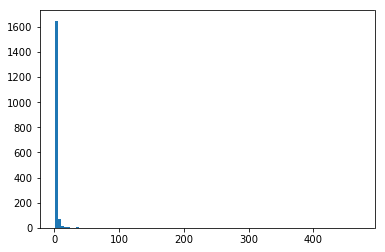

In [54]:
degree_array = np.array(list(degrees.values()))
hist = plt.hist(degree_array, bins=100)

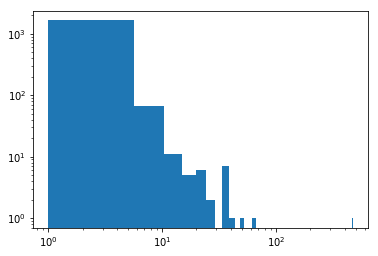

In [55]:
# using logarithmic scales
hist = plt.hist(degree_array, bins=100, log=True)
plt.xscale('log')


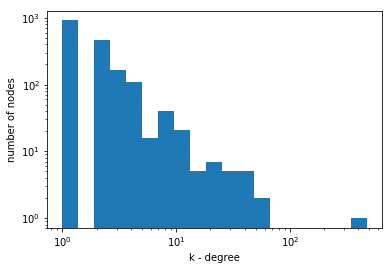

In [56]:
# logarithmic scale with logarithmic bins
N, bins, patches = plt.hist(degree_array, bins=np.logspace(0,np.log10(degree_array.max()+1), 20), log=True)
plt.xscale('log')
plt.xlabel('k - degree')
plt.ylabel('number of nodes')


1.0


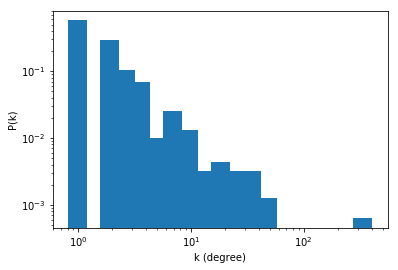

In [57]:
# Degree probability distribution (P(k))

# since we have logarithmic bins, we need to
# take into account the fact that the bins 
# have different lenghts when normalizing
bin_lengths = np.diff(bins) # lenght of each bin

summ = np.sum(N*bin_lengths)
normalized_degree_dist = N/summ

# check normalization:
print(np.sum(normalized_degree_dist*bin_lengths))

hist = plt.bar(bins[:-1], normalized_degree_dist, width=np.diff(bins))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (degree)')
plt.ylabel('P(k)')

### Exercise: do the same for the Graph comprising only retweet, replies, quote and mentions

### Percolation of the Giant Component

In [58]:
import random

def getGCsize(G):
    """ returns the size of the largest component of G"""
        
    comps = nx.connected_components(G)
    return max([len(comp) for comp in comps])
    


#### Random Attack:

In [59]:
# list that will contain the size of the GC as we remove nodes
rnd_attack_GC_sizes = []

# we will take into account the undirected version of the graph
LCCundirected = nx.Graph(LCC)

nodes_list = LCCundirected.nodes()


while len(nodes_list) > 1:
    # add the size of the  current GC
    rnd_attack_GC_sizes.append(getGCsize(LCCundirected))
    
    # pick a random node
    rnd_node = random.choice(nodes_list)
    # remove from graph
    LCCundirected.remove_node(rnd_node)
    # remove from node list
    nodes_list.remove(rnd_node)


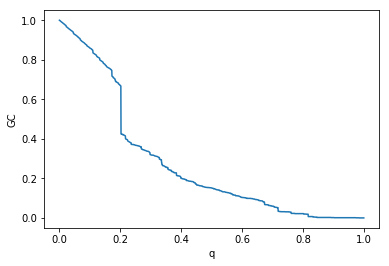

In [60]:
# convert list to numpy array
rnd_attack_GC_sizes = np.array(rnd_attack_GC_sizes)

# normalize by the initial size of the GC
GC_rnd = rnd_attack_GC_sizes/rnd_attack_GC_sizes[0]

# fraction of removed nodes
q = np.linspace(0,1,num=GC_rnd.size)

plt.plot(q,GC_rnd)
plt.xlabel('q')
plt.ylabel('GC')


#### High degree attack:

In [61]:
# high degree attack
LCCundirected = nx.Graph(LCC)

# list of pairs (node, degree) sorted according the degree
node_deg_dict = nx.degree(LCCundirected)
nodes_sorted = sorted(node_deg_dict, key=node_deg_dict.get)

# list that will contain the size of the GC as we remove nodes
hd_attack_GC_sizes = []

while len(nodes_sorted) > 1:
    
    hd_attack_GC_sizes.append(getGCsize(LCCundirected))
    
    #remove node according to their degree
    node = nodes_sorted.pop()
    LCCundirected.remove_node(node)
    
    



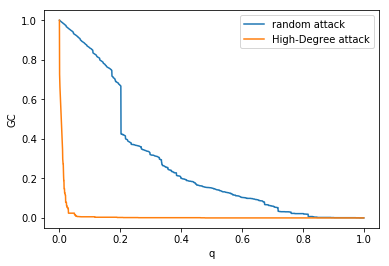

In [62]:
hd_attack_GC_sizes = np.array(hd_attack_GC_sizes)
GC_hd = hd_attack_GC_sizes/hd_attack_GC_sizes[0]
q = np.linspace(0,1,num=GC_hd.size)

plt.plot(q,GC_rnd, label='random attack')
plt.plot(q,GC_hd, label='High-Degree attack')
plt.xlabel('q')
plt.ylabel('GC')
plt.legend()


#### Exercise: implement the High-Degree Adaptative (HDA) attack where at each step the node with the highest degree of the remaining graph is removed.

### Save the graph to a GraphML file:

GraphML is file format based on XML useful for exchanging files between softwares.

http://graphml.graphdrawing.org/

In [63]:
nx.write_graphml(LCC, 'twitter_lcc.graphml')